###Text, **Image**, Video
**For my image Vault, I use Fuyu to batch describe all the images to get texts and then compose a SOM of the texts.**

### Preparation

Installation and importing

In [6]:
! pip install -q transformers bitsandbytes accelerate
! pip install --upgrade accelerate bitsandbytes
! pip install accelerate
! pip install -i https://test.pypi.org/simple/ bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 34.9 MB/s eta 0:00:00
Looking in indexes: https://test.pypi.org/simple/


In [7]:
import time
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from urllib.request import Request, urlopen
from transformers import AutoTokenizer, FuyuProcessor, FuyuImageProcessor, FuyuForCausalLM, BitsAndBytesConfig
import pdb

Helper functions

In [8]:
def url_to_image(url):
  """get image from web url"""
  #definition of User-Agent in header due to website blocking, also see here: https://stackoverflow.com/questions/16627227/problem-http-error-403-in-python-3-web-scraping
  req = Request(url=url, headers={'User-Agent': 'Mozilla/6.0'})
  resp = urlopen(req).read()
  image = np.asarray(bytearray(resp), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return image

def show(image):
  """show an image in line"""
  cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

def pprint(text, line_char=88):
  """pretty print text by limit line characters"""
  last_char = "" # handle last word in each line
  for i in range(0, len(text), line_char):
    line = text[i:i+line_char]
    line = last_char+line
    last_char = ""
    line = line.split(" ")
    last_char = line[-1]
    if i <= len(text)-line_char:
      # handle last word in last line
      line = line[:-1]
    print(" ".join(line))

def run_example(prompt, img_url):
  """run example with prompt and image url"""
  # get and show image
  image = url_to_image(img_url)
  show(image)
  # run the model
  output = fuyu.prompt(prompt, image, out_tokens=100)
  # pretty print example info
  pprint(f"\nGiven \x1b[1;31mimage\x1b[0m \x1B[3m{img_url}\x1B[0m \x1b[1;31mand\x1b[0m the following \x1b[1;31mprompt\x1b[0m:\n\n\x1B[3m{prompt}\x1B[0m", 80)
  pprint(f"The \x1b[1;31mmodels output\x1b[0m:\n\n\x1B[3m{output}\x1B[0m\n", 88)

In [9]:
import torch

Model Definition: Change the Google Colab Runtime type to T4GPU

In [10]:
# check runtime type
if torch.cuda.is_available():
  model_id="ybelkada/fuyu-8b-sharded"
  print(f"\nUsing the sharded model '{model_id}' with to GPU usage.\n")
  print("This model is faster due to 4bit quantization and GPU computation. 🚀\n")
else:
  model_id="adept/fuyu-8b"
  print(f"\nUsing the original model '{model_id}' without GPU usage.\n")
  print("This model, as of today, can't be 4bit quantized. Also the weights can't be fully loaded into memory in colab free tier.")
  print("Running it on CPU and without the above optimizations makes it extremely slow in computation, however you can still do it and run this 8 billion parameter model!\n")
  print("⚠️ For the sake of time, switch the runtime type to 'T4 GPU' or any other GPU type, otherwise it will take literally hours!\n")


Using the sharded model 'ybelkada/fuyu-8b-sharded' with to GPU usage.

This model is faster due to 4bit quantization and GPU computation. 🚀



In [11]:
import torch

if torch.cuda.is_available():
    model_id = "ybelkada/fuyu-8b-sharded"
    print(f"\nUsing the sharded model '{model_id}' with GPU usage.\n")
    print("This model is faster due to 4bit quantization and GPU computation. 🚀\n")
else:
    print("Error: GPU not available. Please ensure you have access to a GPU and CUDA is properly configured.")


Using the sharded model 'ybelkada/fuyu-8b-sharded' with GPU usage.

This model is faster due to 4bit quantization and GPU computation. 🚀



In [12]:
class Fuyu():
    """Pretrained fuyu model of Adept via huggingface"""

    def __init__(self, model_id="ybelkada/fuyu-8b-sharded"):
        # check if GPU can be used
        if torch.cuda.is_available():
            print("You are running the model on GPU.")
            self.device = torch.device("cuda")
            self.dtype = torch.float16
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=self.dtype
            )
            self.model = FuyuForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)
        else:
            print("You are running the model on CPU, the runtime might be very slow. 🐌")
            self.device = torch.device("cpu")
            self.dtype = torch.bfloat16
            # 4bit quantization is currently not working with the latest version of transformers (as of today: 4.35.0.dev0), it is working with transformers 4.30, however fuyu is not integrated there.
            self.model = FuyuForCausalLM.from_pretrained(model_id, device_map=self.device, torch_dtype=self.dtype)

        # initialize tokenizer and fuyu processor, pretrained and via huggingface
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.processor = FuyuProcessor(image_processor=FuyuImageProcessor(), tokenizer=self.tokenizer)

    def prompt(self, text, image=None, out_tokens=50):
        """Prompt the model with a text and optional an image prompt."""

        if image is None:
            # if no image is provided, use a small black image
            # Warning: This is working but the model is not trained on this image fake. Test purpose only!
            image = np.zeros((30,30,3), dtype=np.uint8)

        # pre processing image and text
        inputs = self.processor(text=text, images=[image], return_tensors="pt").to(self.device)
        prompt_len = inputs["input_ids"].shape[-1]

        # process
        t0 = time.time()
        generation_output = self.model.generate(**inputs, max_new_tokens=out_tokens, pad_token_id=self.tokenizer.eos_token_id)
        print(f"\nGeneration time: {time.time()-t0:.0f}s")

        # post processing
        generation_text = self.tokenizer.decode(generation_output[0][prompt_len:], skip_special_tokens=True)
        return generation_text.lstrip()

### Model Instantiation

In [13]:
fuyu = Fuyu(model_id)

You are running the model on GPU.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/60.5k [00:00<?, ?B/s]

model-00001-of-00011.safetensors:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

model-00002-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00003-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00004-of-00011.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00005-of-00011.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00006-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00007-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00008-of-00011.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00009-of-00011.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model-00010-of-00011.safetensors:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

model-00011-of-00011.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/848 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/6.13M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

### Testing

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


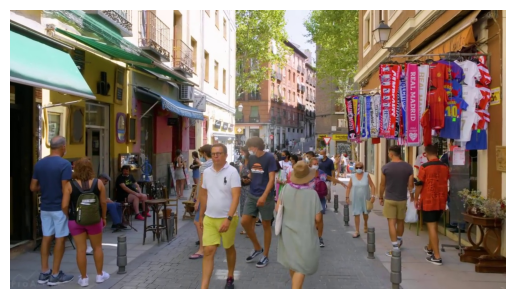

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
file_path ='/content/drive/My Drive/Images/keyframe_0.jpg'
img = Image.open(file_path).convert('RGB')

plt.imshow(img)
plt.axis('off')
plt.show()

In [16]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Modify the url_to_image function to read from a local file
def file_to_image(file_path):
    """get image from local file path"""
    if os.path.exists(file_path):
        image = Image.open(file_path).convert('RGB')
        return image
    else:
        raise FileNotFoundError(f"File not found: {file_path}")

# Modify the run_example function to accept a local file path
def run_example(prompt, img_path):
    """run example with prompt and image file path"""
    # get and show image
    image = file_to_image(img_path)
    file_name = os.path.basename(img_path)
    print(file_name)

    # run the model
    output = fuyu.prompt(prompt, image, out_tokens=60)

    return output

In [17]:
image_path ='/content/drive/My Drive/Images/keyframe_0.jpg'
text_prompt = 'Explain what objects are in this image in a sentence.'

generation_text = run_example(text_prompt,image_path)
generation_text

keyframe_0.jpg

Generation time: 5s


'There are multiple people walking down a street, some carrying handbags and backpacks. Among them, a man is wearing a white shirt and yellow shorts.\n'

### Batch-parsing 1000+ Images

In [18]:
import os
import shutil

def move_images_to_subfolders(source_folder, destination_folder, batch_size=200):
    os.makedirs(destination_folder, exist_ok=True)

    file_list = os.listdir(source_folder)
    file_list.sort()

    num_subfolders = len(file_list) // batch_size + (1 if len(file_list) % batch_size != 0 else 0)

    for i in range(num_subfolders):
        subfolder_path = os.path.join(destination_folder, f'subImagefolder_{i+1}')
        os.makedirs(subfolder_path, exist_ok=True)

        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, len(file_list))

        for j in range(start_index, end_index):
            file_name = file_list[j]
            source_file_path = os.path.join(source_folder, file_name)
            destination_file_path = os.path.join(subfolder_path, file_name)
            shutil.move(source_file_path, destination_file_path)

In [19]:
source_folder = '/content/drive/My Drive/Images'
destination_folder = '/content/drive/My Drive/Datasets_Images/'

move_images_to_subfolders(source_folder, destination_folder, batch_size=200)

In [20]:
import os

def list_files_in_directory(directory):
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return files

In [21]:
output_list=[]
image_path_list=[]

In [22]:
folder_path = '/content/drive/My Drive/Datasets_Images/subImagefolder_1'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

keyframe_12.jpg

Generation time: 4s
keyframe_14.jpg

Generation time: 6s
keyframe_23.jpg

Generation time: 4s
keyframe_25.jpg

Generation time: 3s
keyframe_21.jpg

Generation time: 3s
keyframe_22.jpg

Generation time: 3s
keyframe_18.jpg

Generation time: 2s
keyframe_19.jpg

Generation time: 3s
keyframe_13.jpg

Generation time: 3s
keyframe_10.jpg

Generation time: 3s
keyframe_16.jpg

Generation time: 3s
keyframe_20.jpg

Generation time: 3s
keyframe_102.jpg

Generation time: 3s
keyframe_105.jpg

Generation time: 4s
keyframe_103.jpg

Generation time: 3s
keyframe_125.jpg

Generation time: 4s
keyframe_114.jpg

Generation time: 5s
keyframe_121.jpg

Generation time: 4s
keyframe_127.jpg

Generation time: 4s
keyframe_122.jpg

Generation time: 3s
keyframe_119.jpg

Generation time: 4s
keyframe_110.jpg

Generation time: 5s
keyframe_128.jpg

Generation time: 3s
keyframe_109.jpg

Generation time: 6s
keyframe_126.jpg

Generation time: 4s
keyframe_117.jpg

Generation time: 4s
keyframe_104.jpg

Genera

In [23]:
len(output_list)

200

In [24]:
folder_path = '/content/drive/My Drive/Datasets_Images/subImagefolder_2'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

keyframe_26.jpg

Generation time: 8s
keyframe_35.jpg

Generation time: 4s
keyframe_33.jpg

Generation time: 5s
keyframe_32.jpg

Generation time: 3s
keyframe_36.jpg

Generation time: 3s
keyframe_34.jpg

Generation time: 3s
keyframe_37.jpg

Generation time: 2s
keyframe_30.jpg

Generation time: 6s
keyframe_40.jpg

Generation time: 4s
keyframe_38.jpg

Generation time: 3s
keyframe_27.jpg

Generation time: 4s
keyframe_28.jpg

Generation time: 4s
keyframe_259.jpg

Generation time: 4s
keyframe_290.jpg

Generation time: 4s
keyframe_264.jpg

Generation time: 5s
keyframe_275.jpg

Generation time: 3s
keyframe_304.jpg

Generation time: 4s
keyframe_273.jpg

Generation time: 5s
keyframe_261.jpg

Generation time: 2s
keyframe_286.jpg

Generation time: 4s
keyframe_300.jpg

Generation time: 5s
keyframe_279.jpg

Generation time: 6s
keyframe_289.jpg

Generation time: 3s
keyframe_294.jpg

Generation time: 4s
keyframe_269.jpg

Generation time: 3s
keyframe_283.jpg

Generation time: 5s
keyframe_288.jpg

Genera

In [25]:
len(output_list)

400

In [26]:
folder_path = '/content/drive/My Drive/Datasets_Images/subImagefolder_3'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

keyframe_60.jpg

Generation time: 9s
keyframe_61.jpg

Generation time: 3s
keyframe_52.jpg

Generation time: 6s
keyframe_59.jpg

Generation time: 5s
keyframe_54.jpg

Generation time: 3s
keyframe_55.jpg

Generation time: 4s
keyframe_49.jpg

Generation time: 5s
keyframe_44.jpg

Generation time: 3s
keyframe_57.jpg

Generation time: 3s
keyframe_51.jpg

Generation time: 4s
keyframe_47.jpg

Generation time: 4s
keyframe_48.jpg

Generation time: 4s
keyframe_46.jpg

Generation time: 3s
keyframe_50.jpg

Generation time: 3s
keyframe_45.jpg

Generation time: 4s
keyframe_440.jpg

Generation time: 3s
keyframe_462.jpg

Generation time: 4s
keyframe_480.jpg

Generation time: 4s
keyframe_451.jpg

Generation time: 4s
keyframe_487.jpg

Generation time: 2s
keyframe_465.jpg

Generation time: 5s
keyframe_438.jpg

Generation time: 4s
keyframe_483.jpg

Generation time: 3s
keyframe_456.jpg

Generation time: 4s
keyframe_466.jpg

Generation time: 3s
keyframe_439.jpg

Generation time: 4s
keyframe_469.jpg

Generatio

In [27]:
len(output_list)

600

In [28]:
folder_path = '/content/drive/My Drive/Datasets_Images/subImagefolder_4'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

keyframe_66.jpg

Generation time: 4s
keyframe_68.jpg

Generation time: 5s
keyframe_64.jpg

Generation time: 3s
keyframe_62.jpg

Generation time: 4s
keyframe_65.jpg

Generation time: 5s
keyframe_73.jpg

Generation time: 6s
keyframe_69.jpg

Generation time: 4s
keyframe_76.jpg

Generation time: 2s
keyframe_77.jpg

Generation time: 6s
keyframe_79.jpg

Generation time: 5s
keyframe_72.jpg

Generation time: 3s
keyframe_74.jpg

Generation time: 4s
keyframe_71.jpg

Generation time: 3s
keyframe_75.jpg

Generation time: 5s
keyframe_78.jpg

Generation time: 6s
keyframe_70.jpg

Generation time: 4s
keyframe_616.jpg

Generation time: 3s
keyframe_674.jpg

Generation time: 3s
keyframe_649.jpg

Generation time: 4s
keyframe_655.jpg

Generation time: 4s
keyframe_661.jpg

Generation time: 3s
keyframe_621.jpg

Generation time: 5s
keyframe_665.jpg

Generation time: 4s
keyframe_635.jpg

Generation time: 3s
keyframe_654.jpg

Generation time: 3s
keyframe_636.jpg

Generation time: 5s
keyframe_642.jpg

Generation

In [29]:
len(output_list)

800

In [30]:
folder_path = '/content/drive/My Drive/Datasets_Images/subImagefolder_5'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

keyframe_80.jpg

Generation time: 5s
keyframe_94.jpg

Generation time: 4s
keyframe_86.jpg

Generation time: 4s
keyframe_89.jpg

Generation time: 5s
keyframe_87.jpg

Generation time: 4s
keyframe_95.jpg

Generation time: 3s
keyframe_97.jpg

Generation time: 3s
keyframe_93.jpg

Generation time: 4s
keyframe_91.jpg

Generation time: 5s
keyframe_82.jpg

Generation time: 3s
keyframe_88.jpg

Generation time: 5s
keyframe_84.jpg

Generation time: 4s
keyframe_92.jpg

Generation time: 3s
keyframe_96.jpg

Generation time: 4s
keyframe_85.jpg

Generation time: 5s
keyframe_81.jpg

Generation time: 7s
keyframe_83.jpg

Generation time: 4s
keyframe_90.jpg

Generation time: 3s
keyframe_800.jpg

Generation time: 3s
keyframe_798.jpg

Generation time: 6s
keyframe_801.jpg

Generation time: 2s
keyframe_805.jpg

Generation time: 4s
keyframe_797.jpg

Generation time: 3s
keyframe_803.jpg

Generation time: 4s
keyframe_804.jpg

Generation time: 3s
keyframe_802.jpg

Generation time: 3s
keyframe_799.jpg

Generation t

In [31]:
len(output_list)

1000

In [32]:
folder_path = '/content/drive/My Drive/Datasets_Images/subImagefolder_6'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

keyframe_98.jpg

Generation time: 3s
keyframe_99.jpg

Generation time: 6s
keyframe_977.jpg

Generation time: 3s
keyframe_997.jpg

Generation time: 6s
keyframe_983.jpg

Generation time: 2s
keyframe_988.jpg

Generation time: 3s
keyframe_980.jpg

Generation time: 5s
keyframe_994.jpg

Generation time: 4s
keyframe_986.jpg

Generation time: 3s
keyframe_996.jpg

Generation time: 6s
keyframe_982.jpg

Generation time: 3s
keyframe_989.jpg

Generation time: 4s
keyframe_979.jpg

Generation time: 4s
keyframe_987.jpg

Generation time: 4s
keyframe_981.jpg

Generation time: 6s
keyframe_990.jpg

Generation time: 5s
keyframe_992.jpg

Generation time: 3s
keyframe_978.jpg

Generation time: 3s
keyframe_991.jpg

Generation time: 3s
keyframe_995.jpg

Generation time: 3s
keyframe_985.jpg

Generation time: 3s
keyframe_984.jpg

Generation time: 3s
keyframe_993.jpg

Generation time: 3s
keyframe_999.jpg

Generation time: 4s
keyframe_998.jpg

Generation time: 3s


In [33]:
len(output_list)

1025

In [34]:
output_list[0]

'In the image, there is a statue of a horse, a statue of a man riding a horse, and a building with a clock tower.\n'

In [35]:
len(image_path_list)

1025

In [36]:
filename_list=[]
for i in range (0,len(image_path_list)):
  filename=os.path.basename(image_path_list[i])
  filename_list.append(filename)

In [37]:
len(filename_list)

1025

###Export CSV

In [39]:
import csv

def write_to_csv(filename_list, output_list, csv_file_path):
    with open(csv_file_path, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Filename', 'Text'])

        for filename, output in zip(filename_list, output_list):
            writer.writerow([filename, output])


csv_file_path = '/content/drive/My Drive/Datasets_Images/Image_Textualisation.csv'
write_to_csv(filename_list, output_list, csv_file_path)